# 2023 예능

In [29]:
import pandas as pd
import numpy as np
from kiwipiepy import Kiwi
import copy
import re
from kiwipiepy.utils import Stopwords
import nltk

from wordcloud import WordCloud # 워드클라우드 제작 라이브러리
import pandas as pd # 데이터 프레임 라이브러리
import numpy as np # 행렬 라이브러리
import matplotlib.pyplot as plt # 워드클라우드 시각화 라이브러리
%matplotlib inline
import konlpy

In [30]:
df = pd.read_csv('./data_program/2023년 화제 예능.csv', encoding='utf-8')

# postdate, body, description, title 칼럼만 사용 
df = df[['postdate', 'body', 'description', 'title']]
df.head()

,postdate,body,description,title
0,20230308,피지컬100 투핫 국가수사본부 두발로티켓팅 서진이네 만찢남 신병캠프 여러분 안녕! ...,<b>2023년<\/b> 새롭게 시작한 <b>화제<\/b>의 <b>예능<\/b>들을...,2023년 화제의 OTT예능 총집합! 오티티공유서비스 에브리뷰로 OTT저렴하게 보세요.
1,20240510,안녕하세요! 종합광고대행사 153프로덕션입니다. 2024년 하반기에도 다채로운 소재...,기대되는 신규<b>예능<\/b> 안내해 드리겠습니다. MBC 장안의 <b>화제<\/...,기대되는 신규예능 안내 - MBC 장안의 화제｜SBS 정글밥 ｜ENA 백종원의 레미...
2,20231227,2023년은 방송 예능이 유튜브 웹예능에 밀렸던 위기를 극복하고 다시금 주목받는 해...,사로잡으며 <b>화제<\/b>성을 높였는데요. 특히 태어난 김에 세계일주 시즌2에서...,2023년 방송 예능의 부활: MBC의 선도적 역할
3,20231229,이제 2023년이 끝나가고 있다.ㅠㅠ 올 한 해 마무리하고자 나만의 올해 엔터테인먼...,이제 <b>2023년<\/b>이 끝나가고 있다.ㅠㅠ 올 한 해 마무리하고자 나만의 ...,[연말] 2023년 최애 드라마 예능 영화는?
4,20230106,결혼 말고 동거 정보 출연진 첫방송 MC 한혜진 이용진 아이키 이수혁 채널A 예능 ...,결혼 말고 동거 정보 출연진 첫방송 MC 한혜진 이용진 아이키 이수혁 채널A <b>...,결혼 말고 동거 정보 출연진 첫방송 MC 한혜진 이용진 아이키 이수혁 채널A 예능 ...


## 1. 전처리

In [31]:
# 전처리할 칼럼들
columns = ['body', 'description', 'title']

# 중복 제거
df.drop_duplicates(subset=columns, inplace=True)

for column in columns:
    # 정규표현식 - 한글, 숫자, 영어 및 공백 이외의 문자 제거
    df[column] = df[column].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Z ]", "", regex=True)
    # 앞뒤 공백 제거
    df[column] = df[column].str.strip()
    # 여러 개의 공백을 하나의 공백으로 변경
    df[column] = df[column].str.replace(' +', " ", regex=True)

# 공백만 있는 칼럼을 NaN으로 변경 후 제거
df[columns] = df[columns].replace('', np.nan)
df.dropna(subset=columns, how='any', inplace=True)

In [43]:
from kiwipiepy import Kiwi

# Kiwi 초기화
kiwi = Kiwi()

# 불용어 리스트 정의 및 파일 로드
additional_stopwords = [
'예능', '2023년', '화제', '방송', '출연', '드라마', '프로그램', '배우', '사람', '공개', '대하',
'모습', '영화', '시즌', '시작', '사랑', '활동', '생각', '콘텐츠', '인기', '작품', '이야기', '멤버',
'영상', '가수', '사진', '이후', '연기', '보이', '데뷔', '시청', '채널', '이후', '오리지널', '사람',
'활동', '출연진', '대상', '정보', '방송', '프로필', '추천', '나이', '예정', '이유', '대상',
'근황', '인스타', '배우', '한국', '소식', '출처', '다양', '진행', '연예', '올해', '제작', '방영',
'시리즈', '때문', '대표', '세계', '시청자', '기대', '연출', '무대', '이미지', '공식', '수상',
'소개', '방영', '오후', '연출', '최고', '제작', '등장', '당시', '인물', '소개', '라인업',
'후보', '이슈', '신규',' 공식', '섭외', '축하', '방법', '게스트', '정도', '감독', '관심',
'활약', '마음', '매력', '기록', '남자', '내용', '가지', '참가자', '출연자', '상황', '그룹', '프로',
'장르', '최근', '관심', '출연자', '출신', '기간', '기준', '특집', '순위', '리뷰', '무료',
'대상'
]

# 불용어 텍스트 파일에서 불용어 읽기
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        stopwords_list = file.read().splitlines()
    return stopwords_list

# 파일에서 불용어 목록 로드
stopwords_file_path = 'stopwords.txt'
file_stopwords = load_stopwords(stopwords_file_path)

# 불용어 리스트 결합
all_stopwords = set(additional_stopwords + file_stopwords)

In [44]:
# 불용어 제거 함수 정의
def remove_stopwords(text, stopwords):
    tokens = kiwi.tokenize(text)
    filtered_tokens = [token.form for token in tokens if token.form not in stopwords]
    return ' '.join(filtered_tokens)

# 전처리 함수 정의
def preprocess_korean(text, analyzer=kiwi, stopwords=all_stopwords):
    my_text = copy.copy(text)
    my_text = my_text.replace('\n', ' ') # (1) 줄바꿈 문자 제거
    my_text = analyzer.space(my_text) # (2) 띄어쓰기 교정
    sents = analyzer.split_into_sents(my_text) # (3) 문장 토큰화
    p = re.compile('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]')
    all_result = []
    for sent in sents:
        token_result = remove_stopwords(sent.text, stopwords) # (4) 형태소 분석 및 불용어 제거
        token_result = p.sub(' ', token_result) # (5) 특수 문자 제거 (=한글을 제외한 문자 제거)
        all_result.append(token_result) # (6) 형태소 분석한 결과를 다시 join
    
    all_result = ' '.join(all_result) # (7) 모든 문장을 하나의 string으로 join

    return all_result

# 품사(명사, 동사, 형용사, 부사) 추출 함수 정의
def wordclass_korean(my_str, kiwi=kiwi):
    result = []
    tokens = kiwi.tokenize(my_str, normalize_coda=True)
    for token in tokens:
        if token.tag in ['NNG', 'NNP', 'NNB']:  # 명사 태그만 추출
            result.append(token.form)
    result = ' '.join(result)
    return result

In [34]:
%%time
# 전처리 함수 적용
for column in columns:
    preprocessed_column = 'preprocessed_' + column 
    df[preprocessed_column] = df[column].apply(lambda x: preprocess_korean(x))

# 품사 추출 함수 적용
preprocessed_columns = ['preprocessed_body', 'preprocessed_title', 'preprocessed_description']
for column in preprocessed_columns:
    df[column] = df[column].apply(wordclass_korean)

df.head()

CPU times: total: 1min 24s
Wall time: 3min 41s


,postdate,body,description,title,preprocessed_body,preprocessed_description,preprocessed_title
0,20230308,피지컬100 투핫 국가수사본부 두발로티켓팅 서진이네 만찢남 신병캠프 여러분 안녕 에...,b2023년b 새롭게 시작한 b화제b의 b예능b들을 소개합니다 에뷰걸이 소개하는 O...,2023년 화제의 OTT예능 총집합 오티티공유서비스 에브리뷰로 OTT저렴하게 보세요,피지컬 투핫 국가 수사본부 발 티켓팅 서진 만찢남 신병 캠프 안녕 에뷰걸 오늘 용 ...,니 에뷰걸 넷플릭스 티빙 웨이브 왓챠 디즈니 플러스 가능 보기 몰,총집합 티 티 공유 서비스 에브리뷰
1,20240510,안녕하세요 종합광고대행사 153프로덕션입니다 2024년 하반기에도 다채로운 소재의 ...,기대되는 신규b예능b 안내해 드리겠습니다 MBC 장안의 b화제b 5월21일 화요일 ...,기대되는 신규예능 안내 MBC 장안의 화제SBS 정글밥 ENA 백종원의 레미제라블 ...,안녕하세요 종합 광고 대행사 프로덕션 하반기 소재 안내 장 화요일 밤 시 전국 로컬...,안내 장 화요일 밤 시 전국 팔 김진호 녹색 아버지 회 스리랑카 촬영,안내 장안 정글 밥 백종원 레미제라블 사생활 현무카세 차트 쇼 언더 커버 간접광고 문
2,20231227,2023년은 방송 예능이 유튜브 웹예능에 밀렸던 위기를 극복하고 다시금 주목받는 해...,사로잡으며 b화제b성을 높였는데요 특히 태어난 김에 세계일주 시즌2에서 기안84는 ...,2023년 방송 예능의 부활 MBC의 선도적 역할,은 유튜브 웹 위기 극복 주목 해 니 김 세계일주 중심 서 화면 변신 성공 살 시도...,성 김 세계일주 기 갠지스 강 강물 유튜브 문명 특급 솔로 연예인 편 기획 중 계,부활 선도 역할
3,20231229,이제 2023년이 끝나가고 있다ㅠㅠ 올 한 해 마무리하고자 나만의 올해 엔터테인먼트...,이제 b2023년b이 끝나가고 있다ㅠㅠ 올 한 해 마무리하고자 나만의 올해 엔터테인...,연말 2023년 최애 드라마 예능 영화는,올 해 마무리 만 엔터테인먼트 부문 개 더 글로리 초 더 글로리 명대사 작가 분 역...,올 해 마무리 만 엔터테인먼트 부문 개 더 글로리 초,연말 최애
4,20230106,결혼 말고 동거 정보 출연진 첫방송 MC 한혜진 이용진 아이키 이수혁 채널A 예능 ...,결혼 말고 동거 정보 출연진 첫방송 MC 한혜진 이용진 아이키 이수혁 채널A b예능...,결혼 말고 동거 정보 출연진 첫방송 MC 한혜진 이용진 아이키 이수혁 채널A 예능 ...,결혼 동거 한혜진 이용진 아이키 이수혁 채널 최대 문제작 채널 최대 문제작 결혼 동...,결혼 동거 한혜진 이용진 아이키 이수혁 채널 최대 문제작 스트릿 우먼 파이터 천 진...,결혼 동거 한혜진 이용진 아이키 이수혁 채널 최대 문제작


In [35]:
# 전처리한 결과 csv로 저장 
df.to_csv('23예능_전처리.csv', index=False, encoding='utf-8-sig')

## 2. 단어 빈도 계산

In [36]:
# 단어 빈도 계산 및 상위 단어 추출 
def explode_and_count(df, column):
    exploded = df[column].str.split().explode()  # 문자열을 단어 단위로 나누어 행으로 펼침
    word_counts = exploded.value_counts().reset_index()  # 단어 빈도 계산
    word_counts.columns = ['word', 'count']  # 컬럼명 설정
    return word_counts

### [preprocessed_body]

In [37]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_body']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [38]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_body = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_body = all_words_body[all_words_body['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_body.head(30)
top_30_words

,word,count
9736,연애,512
2536,넷플릭스,480
15528,티빙,397
11061,음악,330
522,게임,319
585,결혼,310
9633,여행,308
10905,유튜브,308
8117,스타,306
7228,선수,282


### [preprocessed_description]

In [39]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_description']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [40]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_description = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_description = all_words_description[all_words_description['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_description.head(30)
top_30_words

,word,count
1379,연애,43
346,넷플릭스,38
2191,티빙,38
1566,음악,26
957,서바이벌,24
1545,유튜브,23
1056,솔로,22
93,결혼,20
1115,스타,20
2287,피지컬,18


### [preprocessed_title]

In [41]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_title']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [42]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_title = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_title = all_words_title[all_words_title['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_title.head(30)
top_30_words

,word,count
195,넷플릭스,35
871,연애,35
1426,티빙,31
691,솔로,17
1495,피지컬,16
724,스타,13
1222,지구,13
1216,중국,13
1570,화요일,12
1572,환승,12


## 3. 워드 클라우드

참고 사이트: https://serendipity77.tistory.com/entry/영화동감-영화동감-댓글-리뷰-워드-클라우드wordcloud로-만들어보기파이썬-Python 

[엑셀 자동화로 칼퇴하는 김대리의 고군분투기:티스토리]

In [45]:
font_path='C:\\Windows\\Fonts\\malgun.ttf'

### [body WordCloud]

In [46]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_body.set_index('word').to_dict()['count']
dic_word

{'연애': 512,
 '넷플릭스': 480,
 '티빙': 397,
 '음악': 330,
 '게임': 319,
 '결혼': 310,
 '여행': 308,
 '유튜브': 308,
 '스타': 306,
 '선수': 282,
 '솔로': 267,
 '커플': 257,
 '중국': 252,
 '대한민국': 226,
 '서울': 196,
 '서바이벌': 191,
 '일본': 190,
 '마지막': 184,
 '캐릭터': 183,
 '재미': 182,
 '야구': 180,
 '사이': 180,
 '문화': 177,
 '노래': 176,
 '이름': 174,
 '환승': 174,
 '가능': 172,
 '유재석': 172,
 '광고': 169,
 '가족': 169,
 '전현무': 168,
 '덱스': 166,
 '플랫폼': 166,
 '처음': 165,
 '지옥': 164,
 '개인': 164,
 '친구': 164,
 '이혼': 164,
 '아이돌': 163,
 '발표': 161,
 '역할': 159,
 '여성': 155,
 '부문': 155,
 '여자': 152,
 '제공': 151,
 '기획': 151,
 '작가': 150,
 '대상': 150,
 '촬영': 148,
 '경우': 147,
 '국내': 147,
 '연예': 146,
 '시장': 145,
 '웃음': 144,
 '성공': 144,
 '준비': 143,
 '연예인': 143,
 '시대': 141,
 '주목': 138,
 '생활': 138,
 '경험': 137,
 '국가': 137,
 '피지컬': 136,
 '관련': 136,
 '자리': 136,
 '지구': 135,
 '과거': 135,
 '앨범': 133,
 '글로벌': 132,
 '부분': 129,
 '오늘': 128,
 '홈페이지': 127,
 '최강': 127,
 '시절': 125,
 '웹툰': 125,
 '세대': 124,
 '유명': 124,
 '공연': 123,
 '기안': 122,
 '주인공': 122,
 '서비스': 121,
 '관계': 1

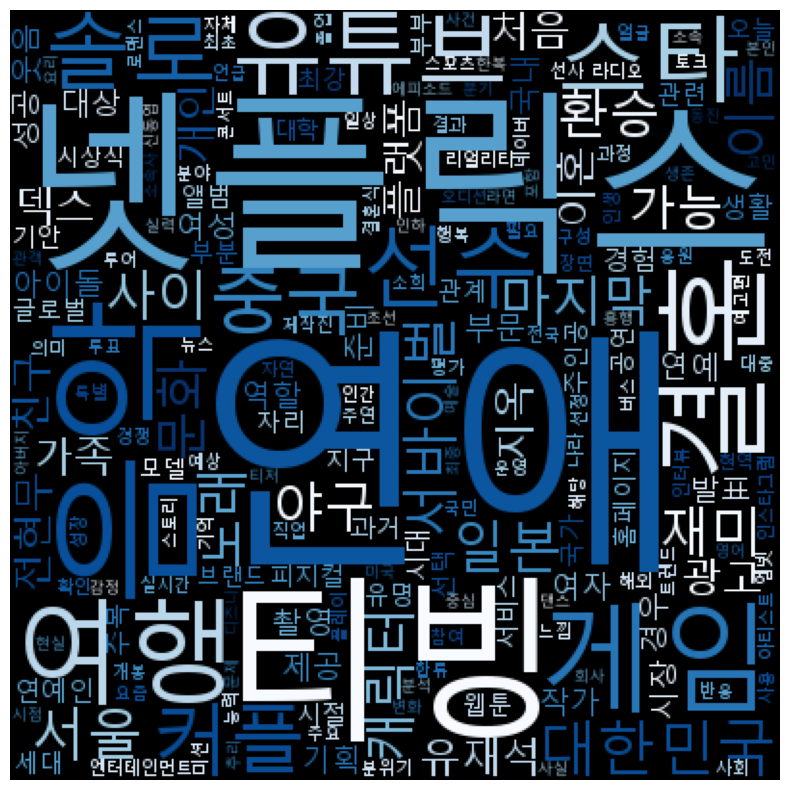

In [47]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues')
               ## 'Blues': 파란색 그라데이션
               ## 'BuGn': 청록색
               ## 'BuPu': 진보라 ~ 연한 파란색 ~ 하얀색 
               ## 'GnBu': 진파랑 ~ 연한 초록색 ~ 하얀색
               ## 'Greys': 검은색 ~ 회색 ~ 하얀색
               ## 'OrRd': 진빨강 ~ 연한 오렌지 ~ 하얀색
               ## 'Pastel1': 파스텔 색
               ## 'Pastel2': 파스텔 색
               ## 'PuBu': 진파랑 ~ 핑크 ~ 하얀색
               ## 'PuRd': 자주 ~ 핑크 ~ 하얀색
               ## 'Purples': 보라색
               ## 'RdPu': 보라 ~ 자주 ~ 핑크
               ## 'Reds': 빨강
               ## 'Wistia': 주황 ~ 형광 노랑
               ## 'YlGnBr': 파랑 ~ 초록 ~ 노랑


img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

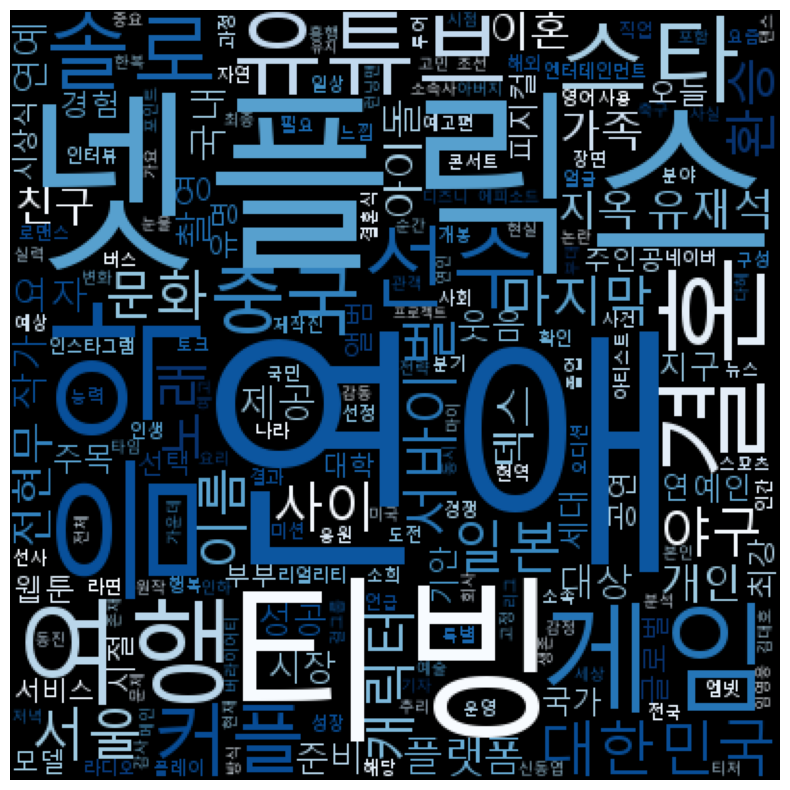

In [49]:
## 불용어 설정
## 참고 사이트: https://coding-yesung.tistory.com/201

from wordcloud import STOPWORDS

# 불용어 리스트
stopwords = {'자체', '최초', '처음', '가능', '생활', '처음', '홈페이지', '주연',
             '역할', '자리', '주연', '과거', '관계', '여성', '부분', '투표', '의미',
             '관계', '관련', '대중', '발표', '광고', '재미', '트렌드', '경우', '반응',
             '분위기', '기획', '주요', '합류', '참여', '중심', '과거', '시대',
             '실시간', '브랜드', '스토리', '기억', '평가', '부문'}

# 불용어 제거
filtered_dic_word = {word: count for word, count in dic_word.items() if word not in stopwords}

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues',
               stopwords = STOPWORDS)

img_wordcloud = wc.generate_from_frequencies(filtered_dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

## [description WordCloud]

In [53]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_description.set_index('word').to_dict()['count']
dic_word

{'연애': 43,
 '넷플릭스': 38,
 '티빙': 38,
 '음악': 26,
 '서바이벌': 24,
 '유튜브': 23,
 '솔로': 22,
 '결혼': 20,
 '스타': 20,
 '피지컬': 18,
 '게임': 16,
 '환승': 16,
 '화요일': 16,
 '금요일': 14,
 '임영웅': 13,
 '지옥': 13,
 '강심장': 12,
 '여행': 12,
 '조선': 12,
 '일본': 11,
 '기획': 11,
 '이혼': 11,
 '토요일': 11,
 '개봉': 10,
 '최초': 10,
 '연예': 10,
 '오늘': 10,
 '리그': 10,
 '타임': 10,
 '대상': 10,
 '리얼리티': 9,
 '하반기': 9,
 '야구': 9,
 '중심': 9,
 '전현무': 9,
 '부대': 9,
 '연예인': 9,
 '대세': 9,
 '아이돌': 9,
 '유재석': 9,
 '버라이어티': 9,
 '선수': 9,
 '국민': 9,
 '토크': 9,
 '촬영': 9,
 '여자': 9,
 '시상식': 9,
 '광고': 9,
 '발표': 9,
 '글로벌': 8,
 '커플': 8,
 '예술': 8,
 '연말': 8,
 '지구': 8,
 '콘서트': 8,
 '소년': 8,
 '미스트': 8,
 '중국': 8,
 '아나운서': 8,
 '주인공': 8,
 '부작': 8,
 '김대호': 8,
 '부문': 8,
 '덱스': 8,
 '플레이': 8,
 '뉴스': 7,
 '나영석': 7,
 '성과': 7,
 '목요일': 7,
 '시대': 7,
 '주년': 7,
 '나라': 7,
 '수요일': 7,
 '일요일': 7,
 '대한민국': 7,
 '년대': 7,
 '기안': 7,
 '노래': 7,
 '라디오': 7,
 '개인': 7,
 '리얼': 7,
 '지나': 7,
 '오디션': 7,
 '쿠팡': 6,
 '제작진': 6,
 '방송사': 6,
 '논란': 6,
 '웨이브': 6,
 '차이': 6,
 '하트': 6,
 '스트리밍': 6,
 '신작': 6,
 '사이': 

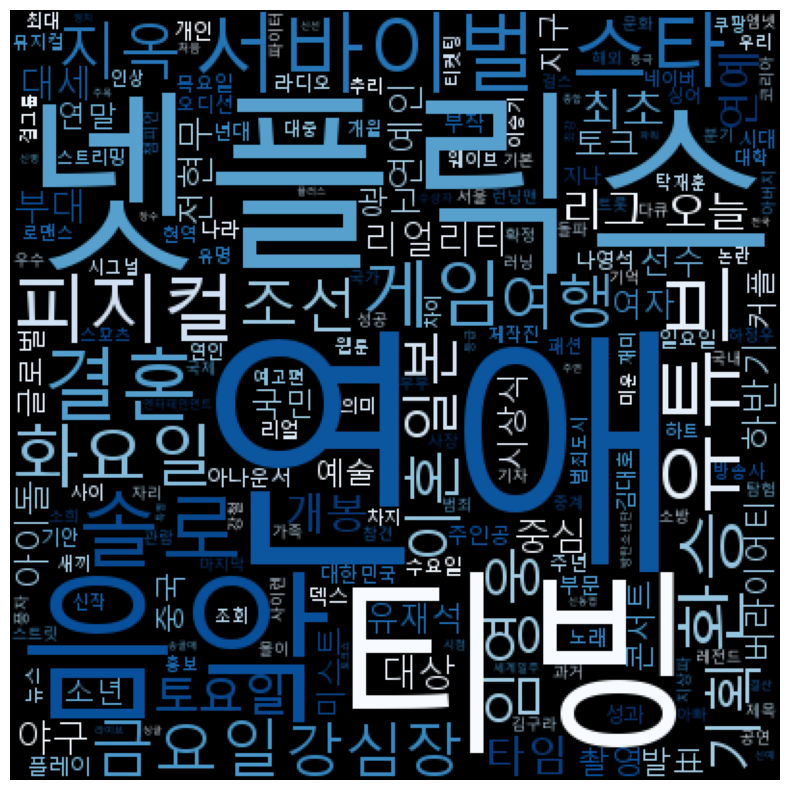

In [54]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

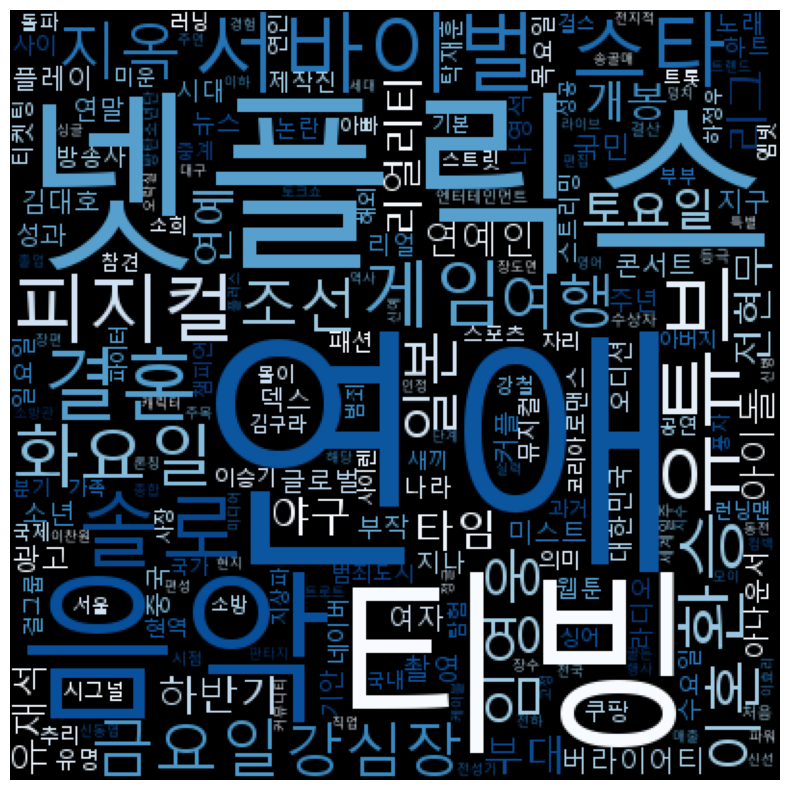

In [57]:
## 불용어 설정
## 참고 사이트: https://coding-yesung.tistory.com/201

from wordcloud import STOPWORDS

# 불용어 리스트
stopwords = {'최대', '대상', '중심', '시상식', '기자', '오늘', '다큐', '재미', '기획',
             '레전드', '발표', '주인공', '우수', '대세', '년대', '최초', '토크', '개인',
             '조회', '풀이', '홍보', '개월', '대중', '예고편', '신작', '전체', '웨이브',
             '인상', '마지막', '예술', '선수', '기억', '확정', '제목', '대학', '문화',
             '관람', '우리', '차지', '부문', '등급', '차이', '최강'}

# 불용어 제거
filtered_dic_word = {word: count for word, count in dic_word.items() if word not in stopwords}

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues',
               stopwords = STOPWORDS)

img_wordcloud = wc.generate_from_frequencies(filtered_dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

## [title WordCloud]

In [58]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_title.set_index('word').to_dict()['count']
dic_word

{'넷플릭스': 35,
 '연애': 35,
 '티빙': 31,
 '솔로': 17,
 '피지컬': 16,
 '스타': 13,
 '지구': 13,
 '중국': 13,
 '화요일': 12,
 '환승': 12,
 '서바이벌': 12,
 '음악': 11,
 '연휴': 10,
 '여행': 10,
 '덱스': 10,
 '오락실': 9,
 '임영웅': 9,
 '커플': 9,
 '유재석': 8,
 '연예': 8,
 '타임': 8,
 '연말': 8,
 '결혼': 8,
 '유튜브': 8,
 '지옥': 8,
 '대상': 8,
 '연예인': 7,
 '헬멧': 7,
 '트렌드': 7,
 '요즘': 7,
 '이혼': 7,
 '야구': 7,
 '기대작': 7,
 '기안': 7,
 '최종': 7,
 '아이돌': 7,
 '신작': 7,
 '열애': 7,
 '콘서트': 7,
 '컴백': 7,
 '직업': 7,
 '중계': 7,
 '결산': 7,
 '세계일주': 6,
 '미스트': 6,
 '현역': 6,
 '투표': 6,
 '투어': 6,
 '소희': 6,
 '파이터': 6,
 '전현무': 6,
 '런닝맨': 6,
 '논란': 6,
 '수상자': 6,
 '공연': 6,
 '걸스': 6,
 '호텔': 6,
 '시상식': 6,
 '문화': 6,
 '대학': 6,
 '디즈니': 6,
 '추리': 5,
 '문의': 5,
 '실시간': 5,
 '수상작': 5,
 '티켓팅': 5,
 '안내': 5,
 '대세': 5,
 '인터뷰': 5,
 '부대': 5,
 '온에어': 5,
 '안현모': 5,
 '김대호': 5,
 '리그': 5,
 '댄스': 5,
 '예고': 5,
 '라디오': 5,
 '정리': 5,
 '정글': 5,
 '결혼전쟁': 5,
 '키워드': 5,
 '베스트': 5,
 '시대': 4,
 '등장인물': 4,
 '사장': 4,
 '장미': 4,
 '스트릿': 4,
 '신병': 4,
 '뿅뿅': 4,
 '주인공': 4,
 '라이머': 4,
 '나영석': 4,
 '플러스': 4,
 '신동엽': 4,
 

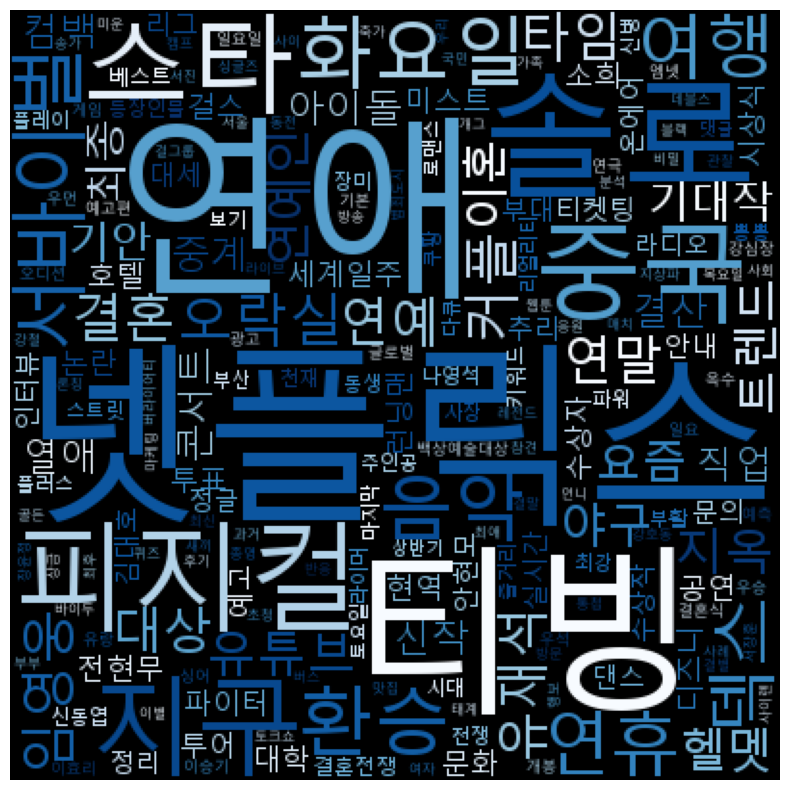

In [59]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

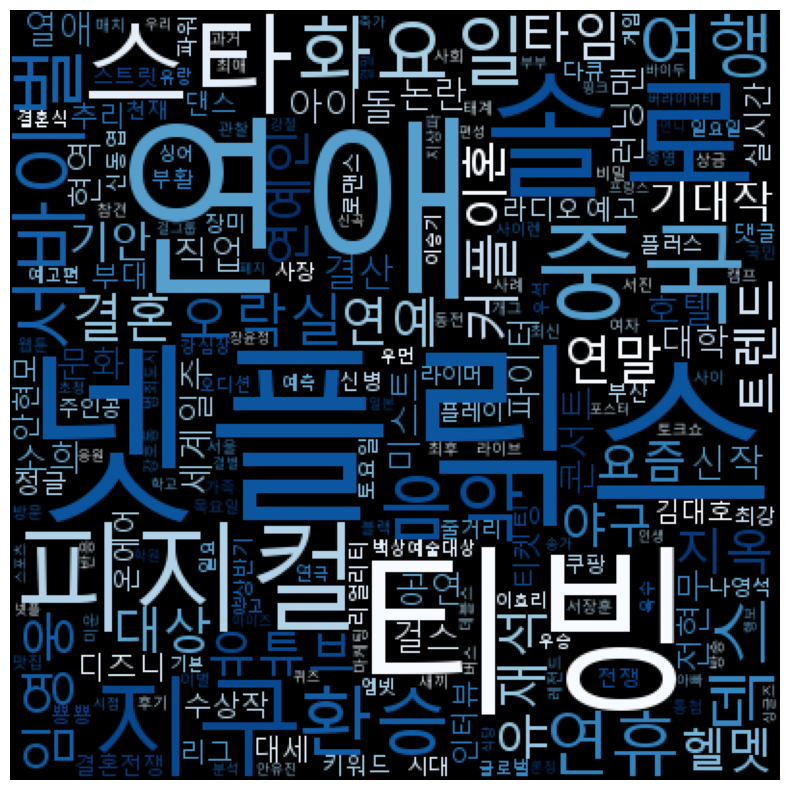

In [61]:
## 불용어 설정
## 참고 사이트: https://coding-yesung.tistory.com/201

from wordcloud import STOPWORDS

# 불용어 리스트
stopwords = {'컴백', '베스트', '최종', '중계', '보기', '정리', '투어', '등장인물', '시상식',
             '안내', '수상자', '문의', '개봉', '투표', '골든', '동생', '마지막'}

# 불용어 제거
filtered_dic_word = {word: count for word, count in dic_word.items() if word not in stopwords}

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues',
               stopwords = STOPWORDS)

img_wordcloud = wc.generate_from_frequencies(filtered_dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기